# Test advanced masking for gslETCCDI 
- author: Johannes L. Fjeldså
- email: johannes.larsen.fjeldså@nmbu.no
## Import libraries

https://www.epa.gov/climate-indicators/climate-change-indicators-length-growing-season 

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

from xclim import ensembles as ens

from src.preproces import *
from src.plotting import *
from src.create_masked_climatology import *
from pathlib import Path


file_handler = Handle_Files()
var = 'gslETCCDI'
main_data_folder = '/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies/nomask/' + var
SSPs = ['ssp126', 'ssp245', 'ssp370', 'ssp585']

## Create climatologies

I have not investigated this dataset before and so we start by creating the basic nomask climatology we do this by running '02 - Create temporal climatology.py'. This yields files such as:

Further we need to performing masking on temporal only climatologies and create global spatial climatologies as well

[2024-02-26 18:45:33.553] [Process: 869107] [error] [1708969533553449532-Global] TileDB internal: Error initializing thread pool of concurrency level 0; Resource temporarily unavailable
[2024-02-26 18:45:33.554] [Process: 869107] [error] [1708969533553449532-Global] TileDB internal: Error initializing thread pool of concurrency level 0; Resource temporarily unavailable


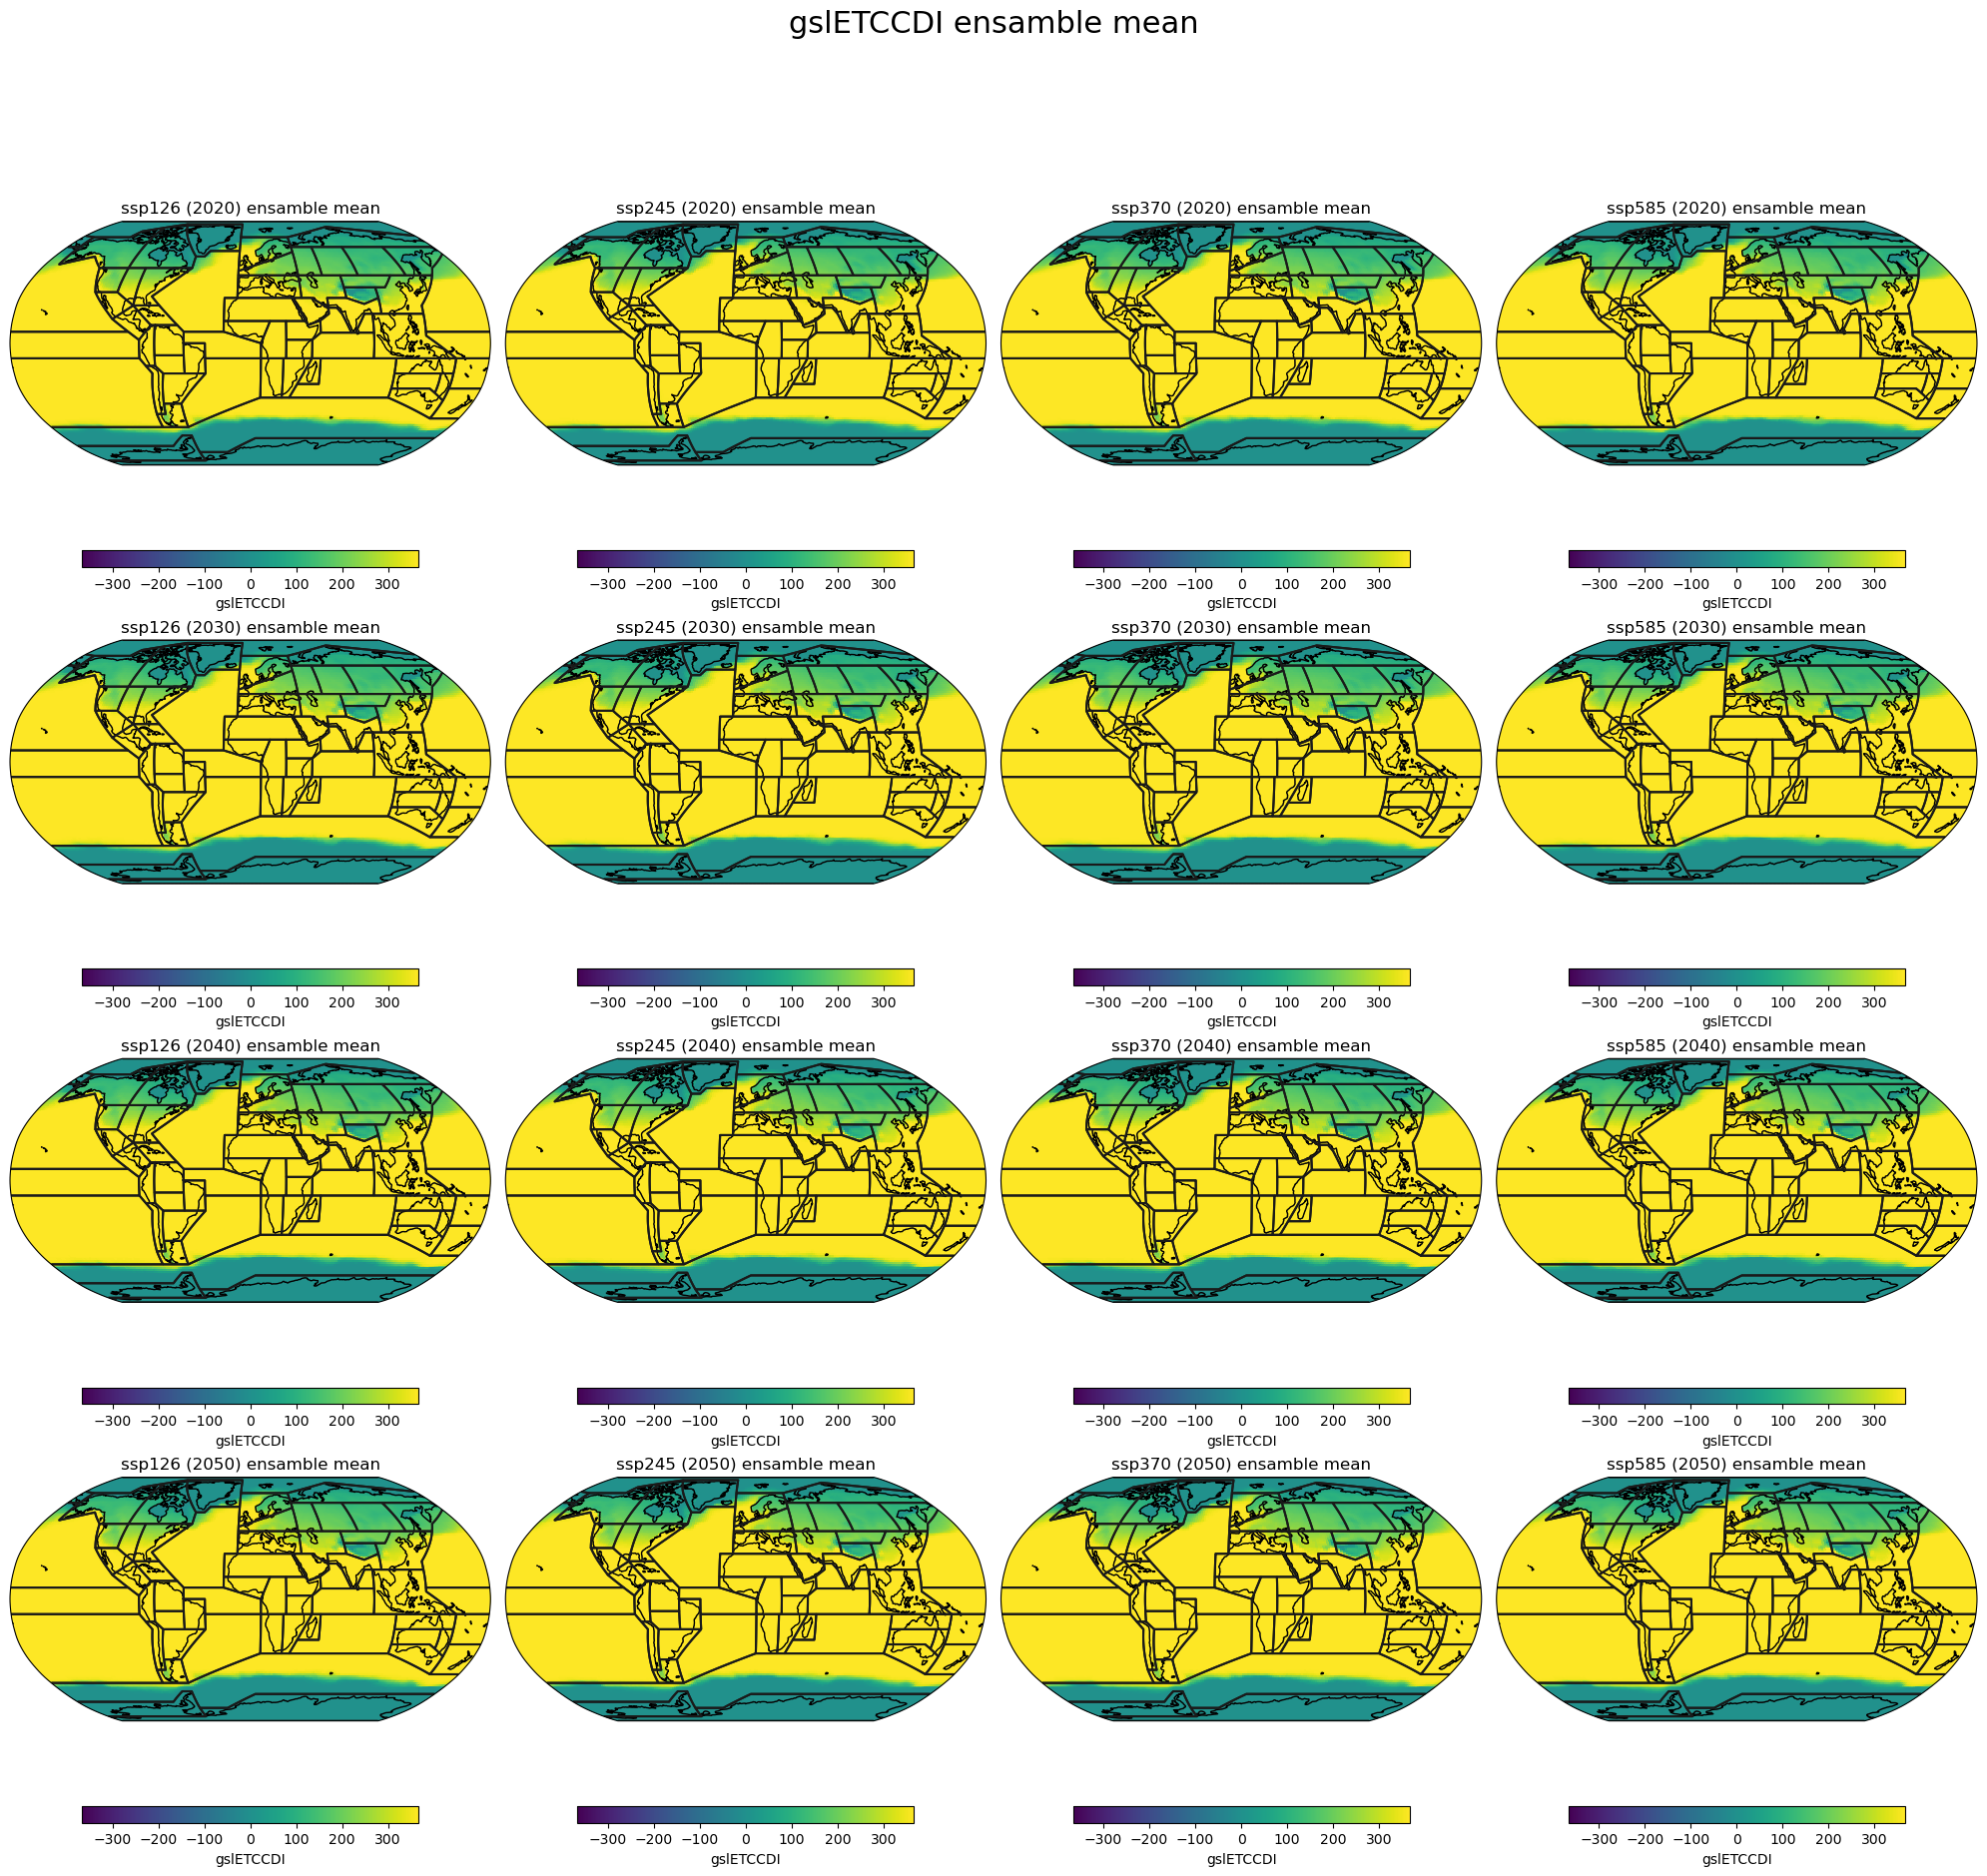

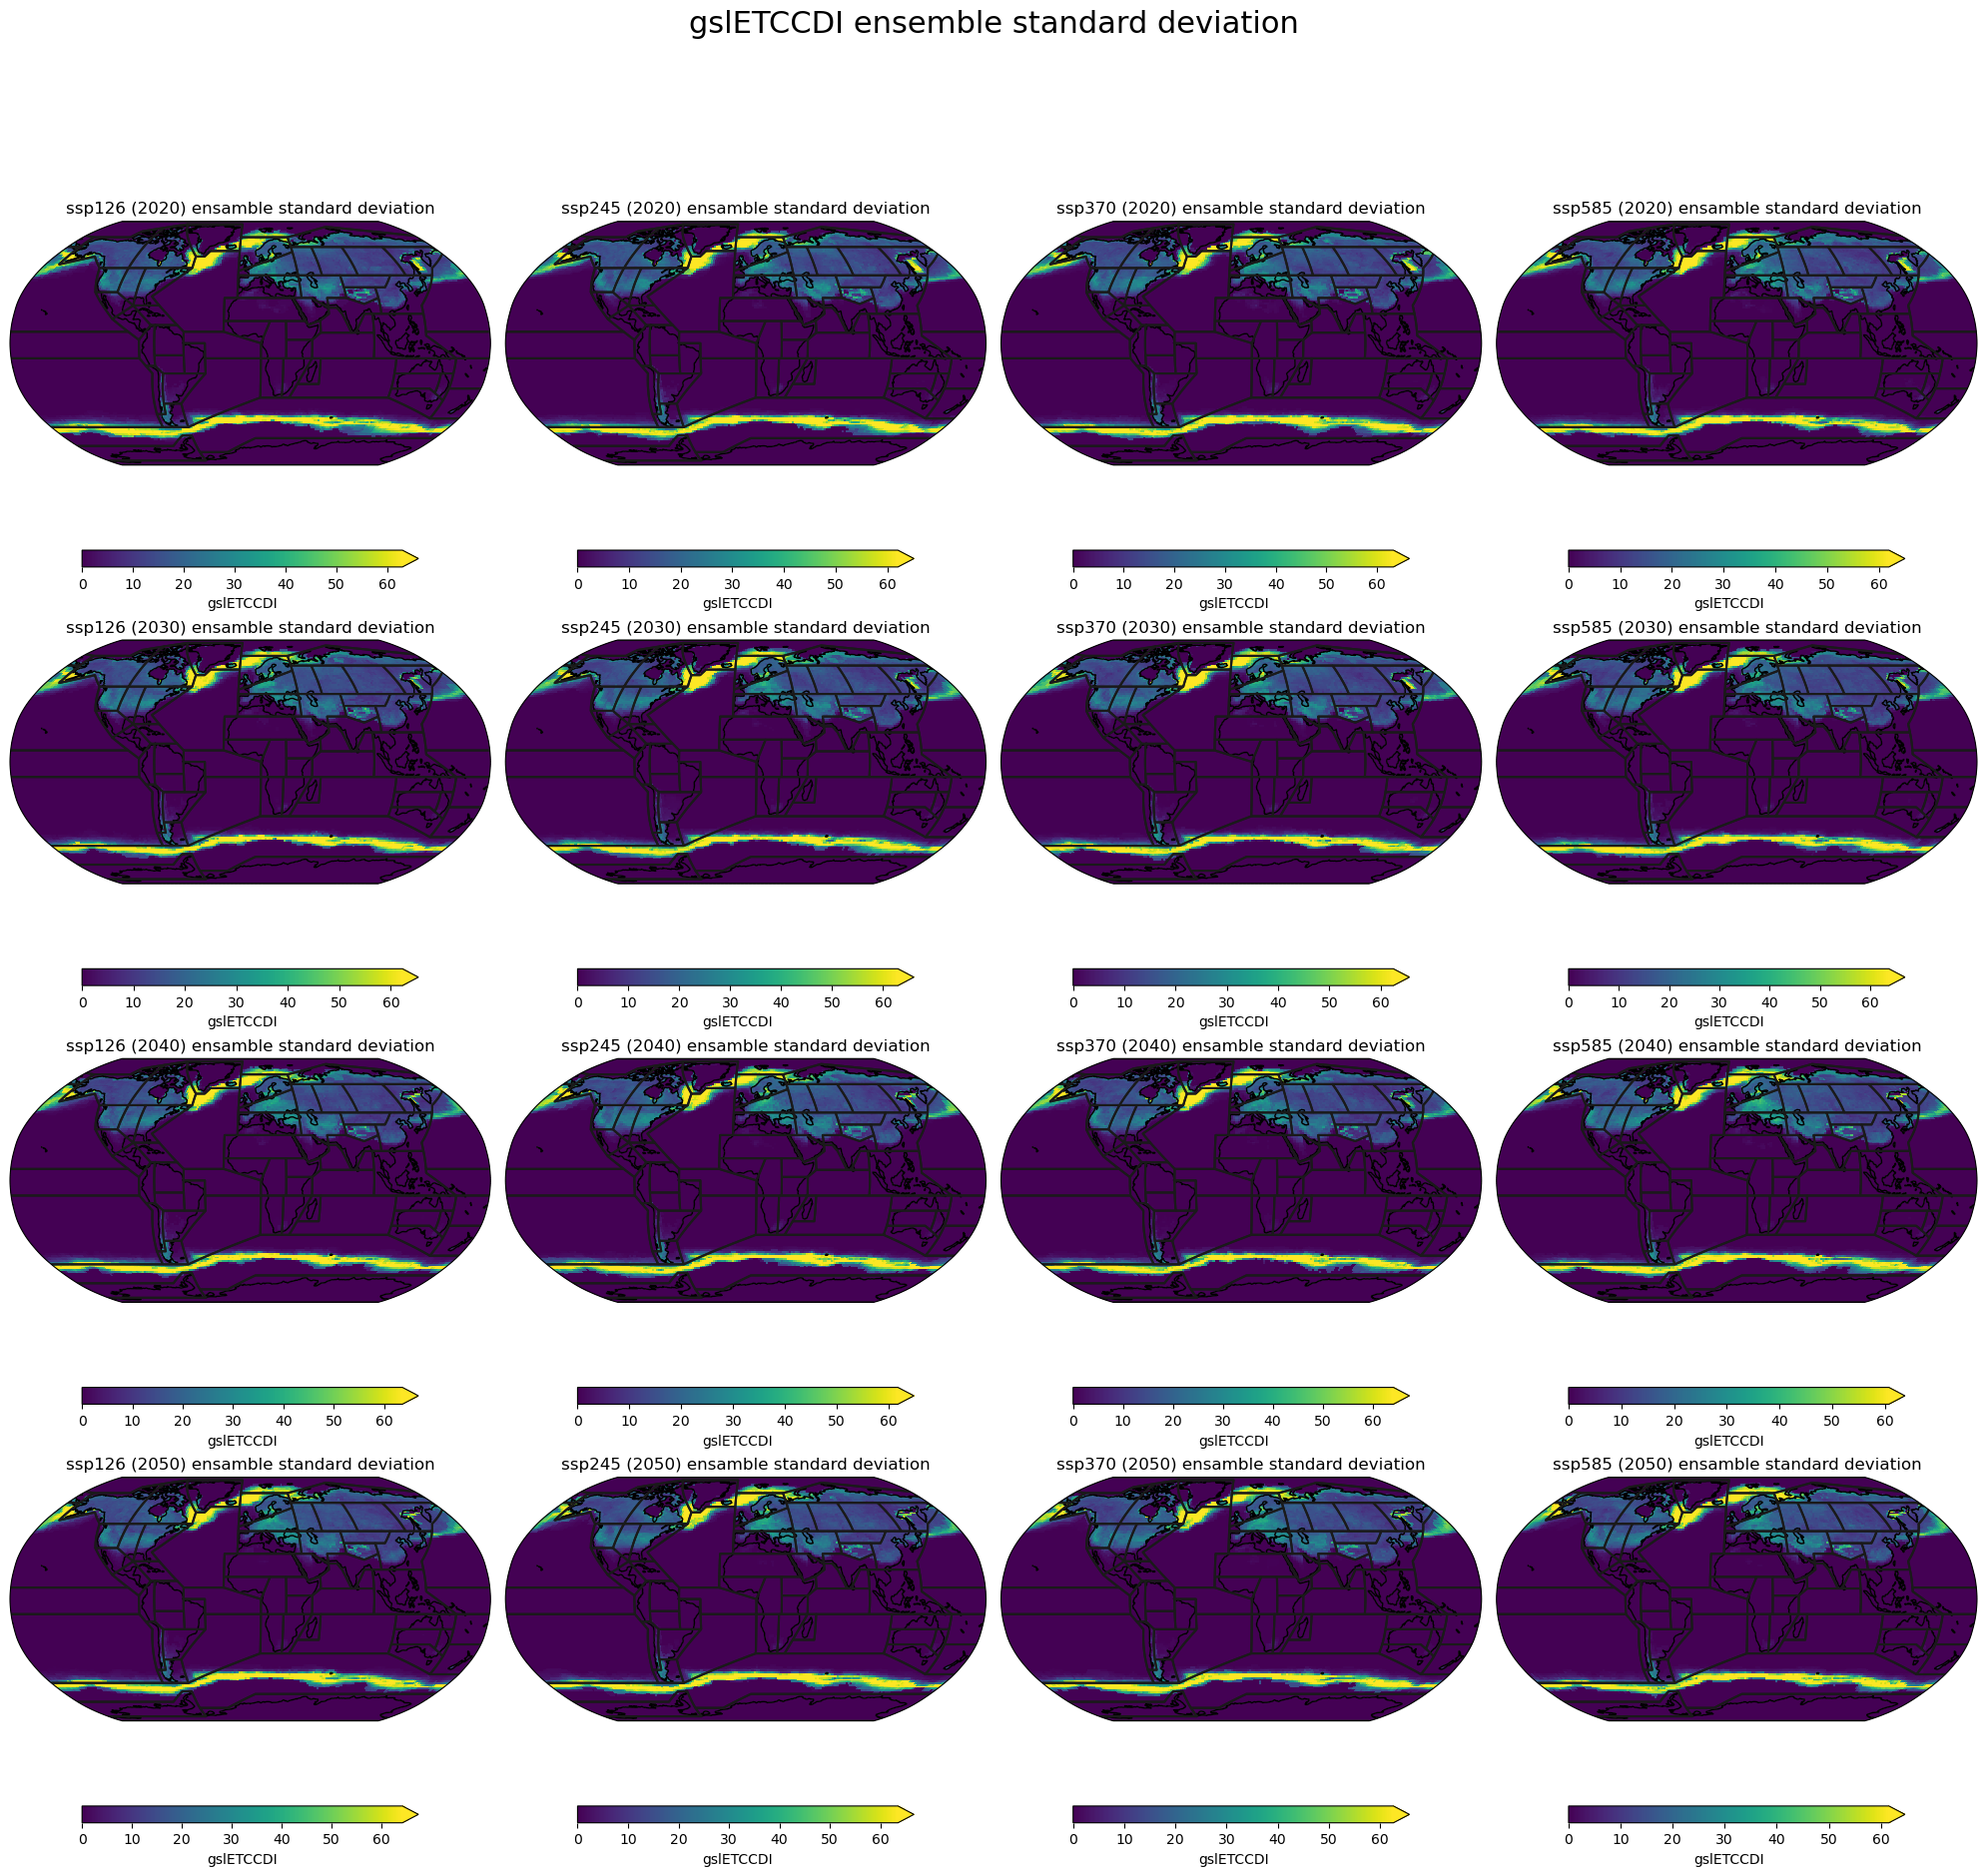

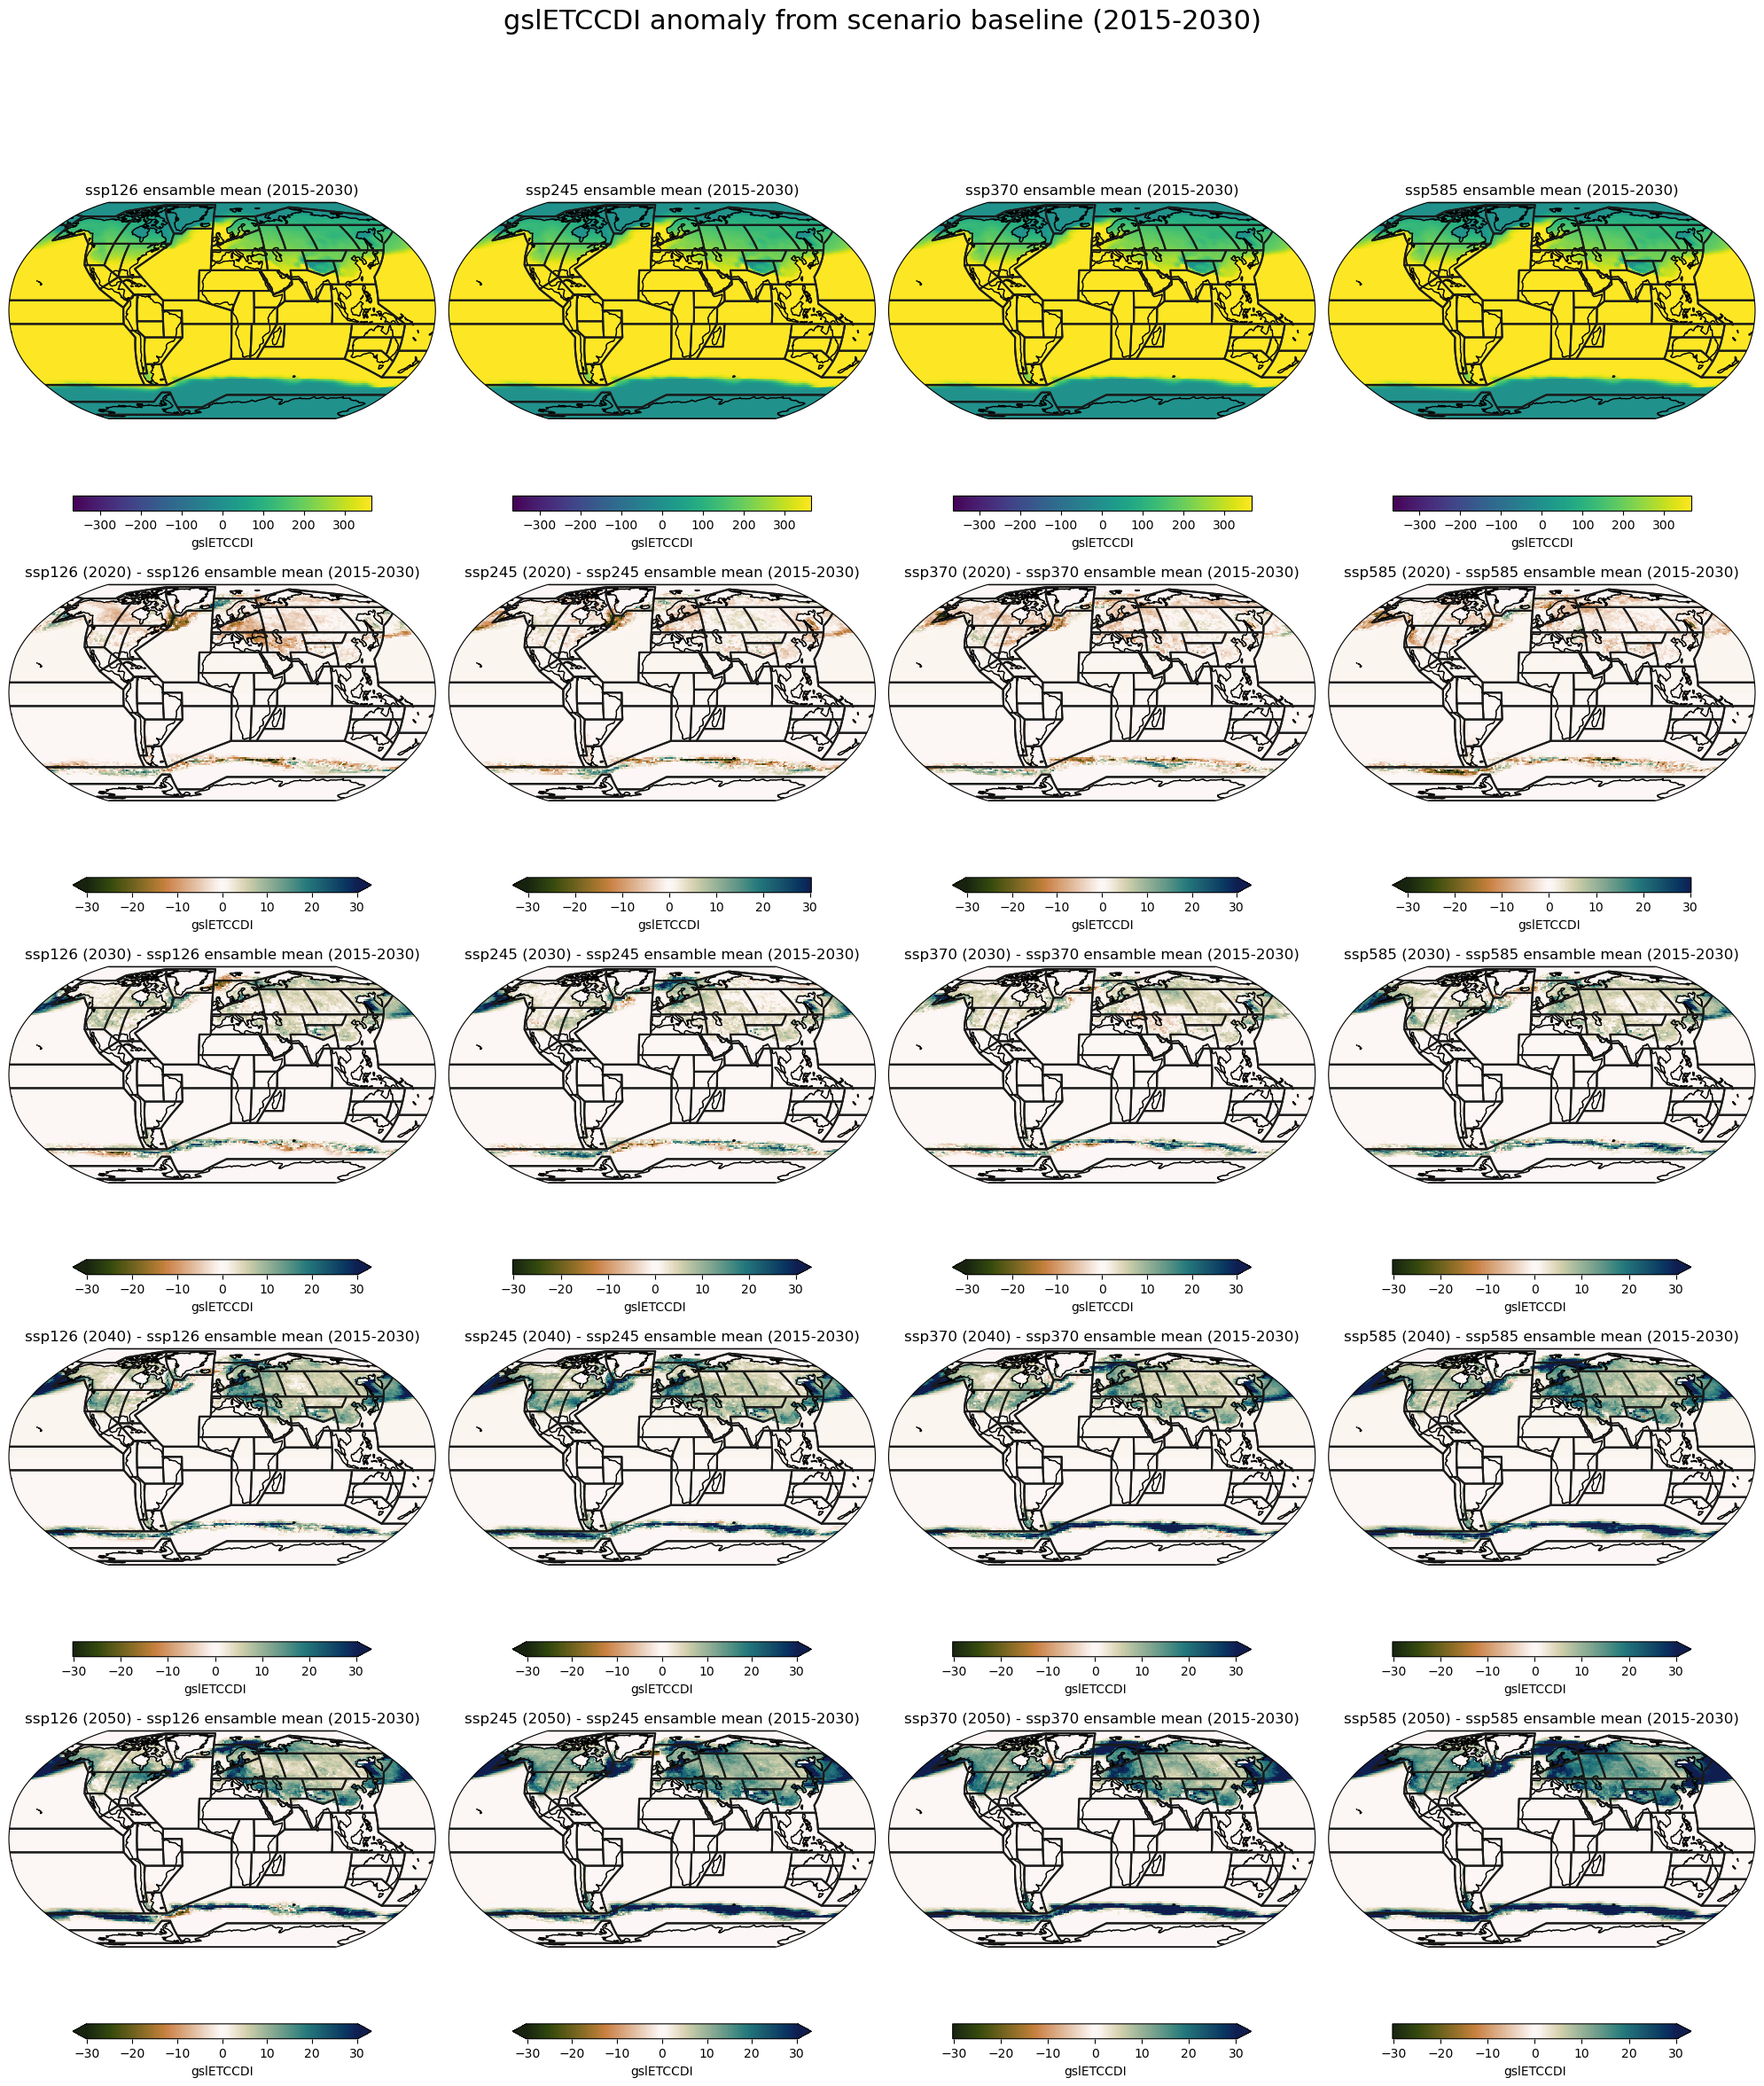

In [4]:
ensambles = {scenario: ens.create_ensemble(Path(main_data_folder + '/' + scenario).glob("*.nc")) for scenario in SSPs}
plot_mapplots_for_investigation(ensambles, var, [2020, 2030, 2040, 2050], SSPs)

## Create unmasked l climatologies

In [1]:
main_data_folder = '/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies/nomask/' + var
main_save_folder = '/nird/home/johannef/Masterthesis_S23 DataFiles/AnnualGlobalClimatologies/nomask/' + var

for scenario in SSPs:
    data_folder = '/'.join([main_data_folder, scenario])
    save_folder = '/'.join([main_save_folder, scenario])
    for file_name in file_handler.get_all_netcdf_files_in_dir(data_folder):
        ds = file_handler.read_netcdf_to_xr(directory=data_folder, file_name=file_name)
        weights = np.cos(np.deg2rad(ds['lat']))
        weights.name = "weights"        
        preprocesser.create_spatial_climatology(ds, var, 
                                                weights, 
                                                climatology_type='global', 
                                                save_to_dataset=True, 
                                                file_name=file_name.replace('.nc', f'_glob.nc'), 
                                                directory=save_folder, 
                                                is_original_name=False, 
                                                re_open=False)

NameError: name 'var' is not defined

# Create masked climatologies

From the ensamble plot we see that the Seamask blurs the transition, an expected effect as it dampens the actual signal. Further we see from the test plot that the interesting informastion is found over land and ind the mid latitudes as the low latitudes has approx 100 % gsl and high latitudes has 0%. We therefor investigate masking 30 to 70 degree north. 

In [19]:
test_file = file_handler.read_netcdf_to_xr('/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies/nomask/gslETCCDI/ssp245/gslETCCDI_yr_ACCESS-ESM1-5_ssp245_r3i1p1f1_2015-2100.nc')
lat_mask_30N_70N = create_latitude_mask(min_lat=30, max_lat=70, 
                                        var='gslETCCDI',
                                        new_mask_name='lat_mask_30N_70N',
                                        test_file=test_file)
land_mask_30N_70N = create_land_sea_latitude_mask(min_lat=30, max_lat=70, 
                                                  new_mask_name='land_mask_30N_70N', 
                                                  land=True)

for mask, file_name in zip([lat_mask_30N_70N, land_mask_30N_70N], 
                          ['lat_mask_30N_70N_ACCESS-ESM1-5.nc', 'land_mask_30N_70N_ACCESS-ESM1-5.nc']):
    file_handler.save_dataset_to_netcdf(mask, 
                                    file_name=file_name,
                                    directory='/nird/home/johannef/Masterthesis_S23 DataFiles/masks')

In [23]:
for mask_name in ['lat_mask_30N_70N', 
                  'land_mask', 'land_mask_30N_70N']:
    create_masked_climatologies(mask_name, var,
                                excisting_mask=True, 
                                test_file=test_file)

Investigate ensambles

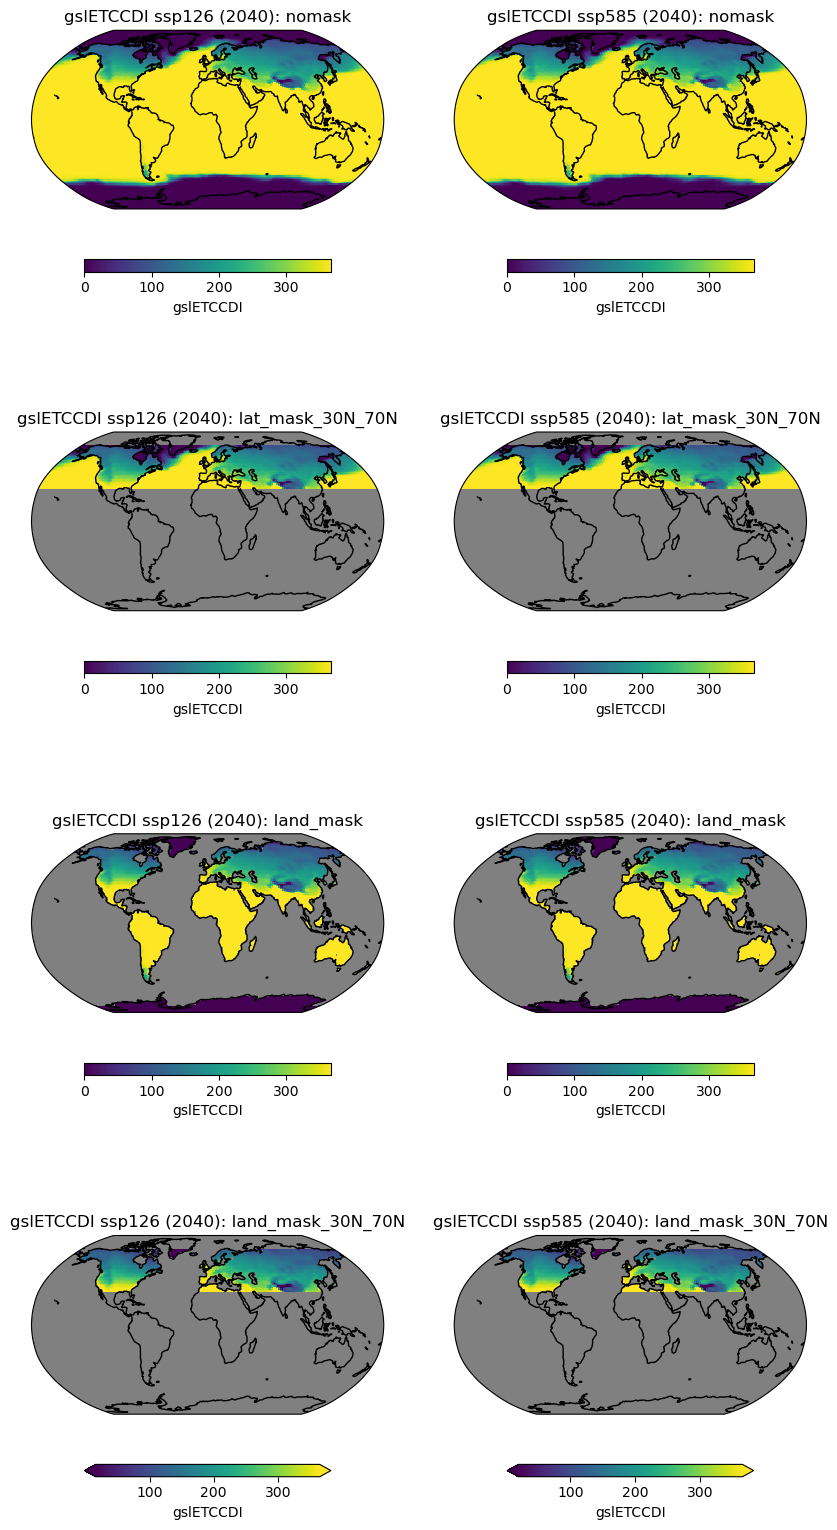

In [24]:
main_data_dir = '/nird/home/johannef/Masterthesis_S23 DataFiles/Annualclimatologies'
SSPs = ['ssp126', 'ssp585']
var = 'gslETCCDI'
mask_names = ['nomask', 'lat_mask_30N_70N', 
              'land_mask', 'land_mask_30N_70N']
fig, axs = plt.subplots(ncols=len(SSPs), nrows=len(mask_names), 
                        figsize=(5*len(SSPs), 5*len(mask_names)),
                        subplot_kw=dict(projection=ccrs.Robinson(central_longitude=0), facecolor="gray"))
axs = axs.flatten()

i = 0
for mask_name in mask_names:
    mask_data_dir = '/'.join([main_data_dir, mask_name, var])
    for scenario in SSPs:
        data_dir = '/'.join([mask_data_dir, scenario])
        ensamble = ens.create_ensemble(Path(data_dir).glob("*.nc")) 
        ensamble_mean = ensamble.mean(dim='realization') 

        plot_on_map(ensamble_mean.sel(year=2040)[var], ax=axs[i], title=f'{var} {scenario} ({2040}): {mask_name}')

        i += 1

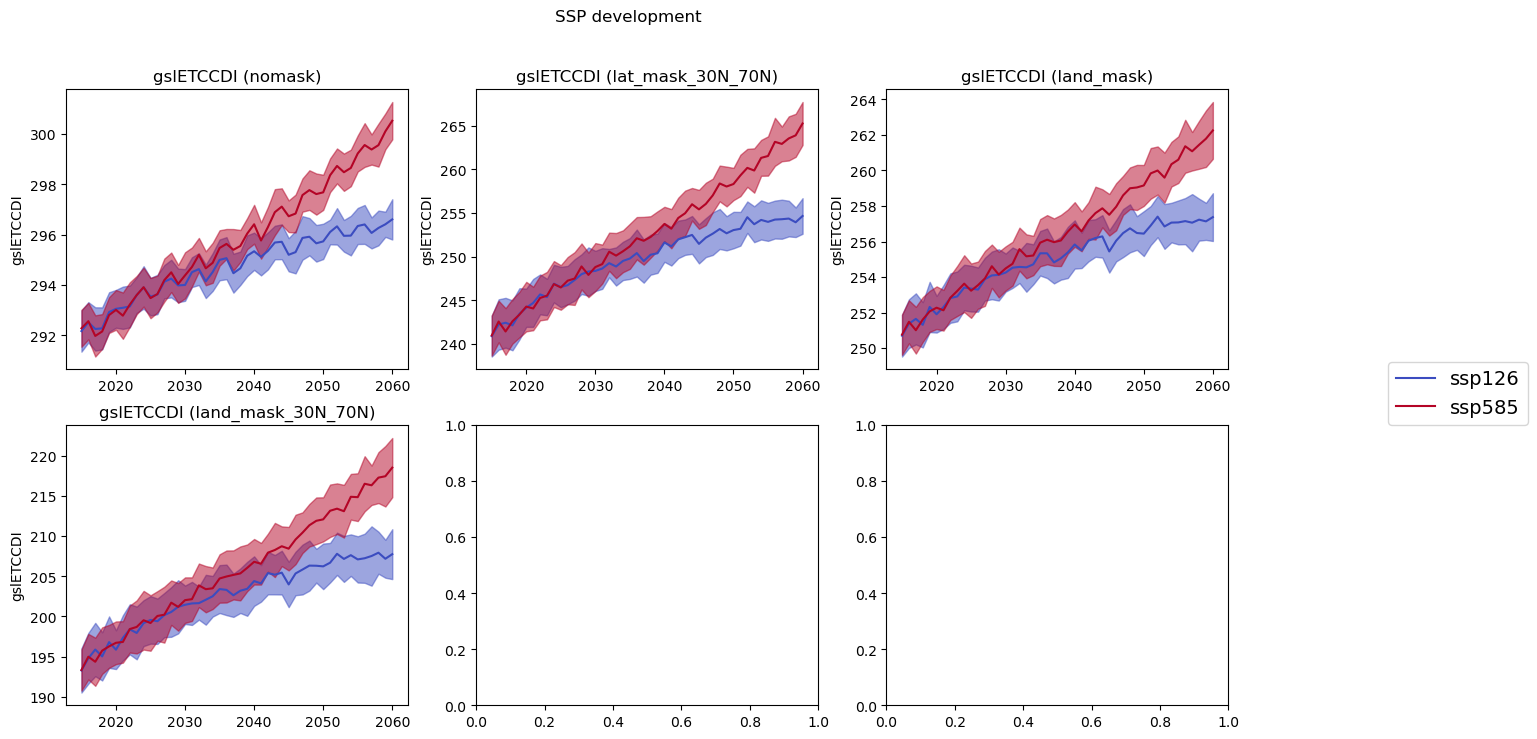

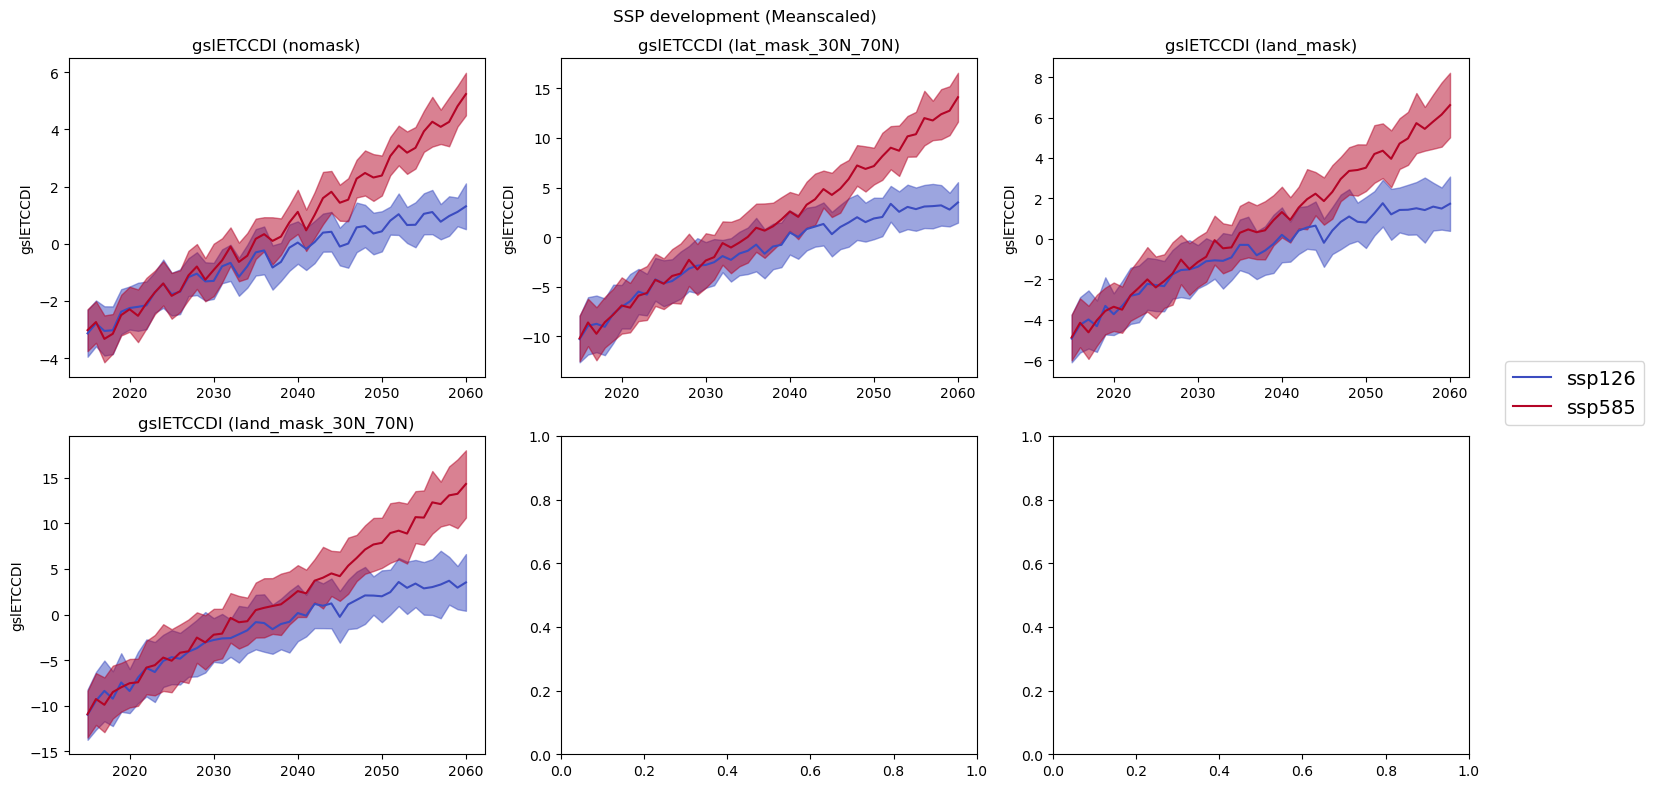

In [25]:
main_data_dir = '/nird/home/johannef/Masterthesis_S23 DataFiles/AnnualGlobalClimatologies'
plot_annual_global_ensambles(main_data_dir, SSPs, var,
                             mask_names, temporal_range=(2015, 2060))

The latitude masking is noise reducing I will keep:
- nomask
- lat_mask_30N_70N
- land_mask_30N_70N